In [1]:
import torch
from torch.autograd import Variable
from torch import nn
from torch import optim

In [2]:
# 定义最高次项的指数

n = 4

In [3]:
# 为线性相乘做准备，将x中的每一个元素排列成 [x^1, x^2, ..., x^n]
# 因为有多个x，故返回的是一个4x4的二维张量

def make_features(x) :
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in range(1, n + 1)], 1)

In [4]:
# 不加入x^0的原因是，nn.Linear默认自带bias属性（可取消）， 以下来源于http://pytorch.org/docs/master/nn.html
# 在页面内搜索nn.Linear即可找到

## class torch.nn.Linear(in_features, out_features, bias=True)[source]
## Applies a linear transformation to the incoming data: y=Ax+b
##
## > Parameters:
##    - in_features – size of each input sample
##    - out_features – size of each output sample
##    - bias – If set to False, the layer will not learn an additive bias. Default: True

In [5]:
import random
#定义目标函数，包括权重和偏执

W_target = torch.FloatTensor([random.randint(-1000, 1000) * 0.01 for i in range(n)]).unsqueeze(1)
b_target = torch.FloatTensor([random.randint(-100, 1000) * 0.01])

In [6]:
# 定义实际函数

def f(x) :
    return x.mm(W_target) + b_target[0]

In [7]:
# 生成训练集。随机取数，然后生成x，然后生成y

def get_batch(batch_size = 32, random = None) :
    if random is None :
        random = torch.randn(batch_size)
    batch_size = random.size()[0]
    x = make_features(random)
    y = f(x)
    if torch.cuda.is_available() :
        return Variable(x).cuda(), Variable(y).cuda()
    else :
        return Variable(x), Variable(y)

In [8]:
# 构造训练网络模型

class poly_model(nn.Module) :
    def __init__(self, n) :
        super().__init__()
        self.poly = nn.Linear(n, 1)
    def forward(self, x) :
        return self.poly(x)

# 实例化网络模型
if torch.cuda.is_available() :
    poly = poly_model(n).cuda()
else :
    poly = poly_model(n)

In [9]:
# 定义损失函数为均方误差, 定义优化函数为随机梯度下降，学习率为0.03

criterion = nn.MSELoss()
optimizer = optim.SGD(poly.parameters(), lr = 1e-3)

In [10]:
# 开始训练

epoch = 0
while True :
    # 获得数据
    batch_x, batch_y = get_batch()
    # 前向计算
    output = poly(batch_x)
    # 计算损失函数
    loss = criterion(output, batch_y)
    print_loss = loss.data[0]
    # 参数更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch += 1
    if print_loss < 1e-3 :
        break

print("the number of epoches :", epoch)

the number of epoches : 7514


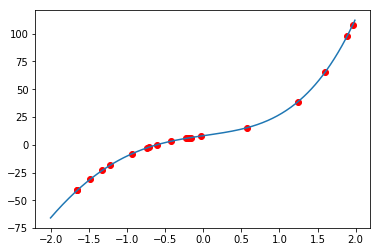

In [12]:
import matplotlib.pyplot as plt
import numpy as np
x = [random.randint(-200, 200) * 0.01 for i in range(20)]
x = np.array(sorted(x))
feature_x, y = get_batch(random = torch.from_numpy(x).float())
y = y.data.numpy()
plt.plot(x, y, 'ro', label='Original data')

poly.eval()
x_sample = np.arange(-2, 2, 0.01)
x, y = get_batch(random = torch.from_numpy(x_sample).float())
y = poly(x)
y_sample = y.data.numpy()
plt.plot(x_sample, y_sample, label = 'Fitting Line')
plt.show()